# First part

In [1]:
!wget -O "guthenberg-cs.txt" "https://www.gutenberg.org/cache/epub/34225/pg34225.txt"
!wget -O "guthenberg-en.txt" "https://www.gutenberg.org/cache/epub/37536/pg37536.txt"

--2026-01-05 14:45:01--  https://www.gutenberg.org/cache/epub/34225/pg34225.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 769766 (752K) [text/plain]
Saving to: ‘guthenberg-cs.txt’

guthenberg-cs.txt   100%[===================>] 751,72K  1,26MB/s    in 0,6s    

2026-01-05 14:45:03 (1,26 MB/s) - ‘guthenberg-cs.txt’ saved [769766/769766]

--2026-01-05 14:45:03--  https://www.gutenberg.org/cache/epub/37536/pg37536.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 724943 (708K) [text/plain]
Saving to: ‘guthenberg-en.txt’

guthenberg-en.txt   100%[===================>] 707,95K  1,23MB/s    in 0,6s    

2026-01

In [ ]:
%pip install sacremoses
%pip install fasttext
%pip install scikit-learn

import fasttext
from sacremoses import MosesTokenizer, MosesDetokenizer
import os
from collections import Counter, defaultdict
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 5.1 MB/s eta 0:00:00m eta 0:00:010:00:01
  Using cached scipy-1.15.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (37.7 MB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
filenames = {"cs": "guthenberg-cs.txt","en": "guthenberg-en.txt"}


In [4]:
for name in filenames:
    print(f"{name}: {os.path.getsize(filenames[name])} bytes")

cs: 769766 bytes
en: 724943 bytes


In [5]:
corpus_full = {}

for lang in filenames:
    with open(filenames[lang], "r") as f:
        corpus_full[lang] = f.read()

data = {lang: MosesTokenizer(lang).tokenize(corpus_full[lang]) for lang in corpus_full}

In [6]:
start_special_symbol, end_special_symbol = "<s>", "</s>"

get_unigrams = lambda tokens : Counter(tokens + [start_special_symbol, end_special_symbol])
get_bigrams = lambda tokens : Counter(zip([start_special_symbol] + tokens, tokens + [end_special_symbol]))
get_trigrams = lambda tokens : Counter(zip(2 * [start_special_symbol] + tokens, [start_special_symbol] + tokens + [end_special_symbol], tokens + 2 * [end_special_symbol]))

In [7]:
print("Length of english tokenized data:", len(data["en"]))
data["en"] = data["en"][:30_000]
print("Length of czech tokenized data:", len(data["cs"]))
data["cs"] = data["cs"][:15_000]
print("Unique tokens in english 30k dataset:", len(set(data["en"])))
print("Unique tokens in czech 15k dataset:", len(set(data["cs"])))

Length of english tokenized data: 149191
Length of czech tokenized data: 136966
Unique tokens in english 30k dataset: 4426
Unique tokens in czech 15k dataset: 4950


In [32]:
uni = {lang: get_unigrams(data[lang]) for lang in data}
bi = {lang: get_bigrams(data[lang]) for lang in data}

starting_words = {
    "en": {w:c for w,c in uni["en"].items() if c >= 50},
    "cs": {w:c for w,c in uni["cs"].items() if c >= 20}
}
print("English tokens with at least 50 occurrences:", len(starting_words["en"]))
print("Czech tokens with at least 20 occurrences:", len(starting_words["cs"]))

English tokens with at least 50 occurrences: 73
Czech tokens with at least 20 occurrences: 77


In [ ]:
def get_class_bigrams(word2class, bigrams):
    class_bigrams = defaultdict(int)
    for (w1, w2), count in bigrams.items():
        c1, c2 = word2class[w1], word2class[w2]
        class_bigrams[(c1, c2)] += count
    return class_bigrams

def get_class_bigrams_matrix(word2class, bigrams):
    class_bigrams_matrix = np.zeros((len(word2class), len(word2class)), dtype=int)
    for (l, r), count in bigrams.items():
        if l not in word2class or r not in word2class:
            continue
        c1, c2 = word2class[l], word2class[r]
        class_bigrams_matrix[c1, c2] += count
    return class_bigrams_matrix

def q(classes_matrix,l,r,N): # q_k(l,r)
    c_k = classes_matrix[l,r]
    c_kl = classes_matrix[l,:].sum()
    c_kr = classes_matrix[:,r].sum()
    if c_kl == 0 or c_kr == 0 or c_k == 0:
        return 0.0
    return c_k / N * np.log(N * c_k / (c_kl * c_kr))

def mutual_information(classes_matrix, N):
    mi = 0
    for i in range(classes_matrix.shape[0]):
        for j in range(classes_matrix.shape[1]):
            mi += q(classes_matrix, i, j, N)
    return mi

def test_merge(c, a, b, N):
    """
    c : matrix[i,j] = # bigrams class i -> class j
    a, b : classes to merge
    should return mutal information difference
    """

    # calculate q on row a,b and column a,b
    # create new matrix with merged row/column
    # calculate q on merged row/column
    # return the difference or whatever

    value = 0.0
    for i in range(c.shape[0]):
        value -= q(c, i, a, N)
        value -= q(c, i, b, N)
        value -= q(c, a, i, N)
        value -= q(c, b, i, N)

    value += q(c, a, a, N)
    value += q(c, b, b, N)
    value += q(c, a, b, N)
    value += q(c, b, a, N)
    
    new_matrix = np.copy(c)
    new_matrix[:,a] += new_matrix[:,b]
    new_matrix[a,:] += new_matrix[b,:]
    new_matrix = np.delete(new_matrix, b, axis=0)
    new_matrix = np.delete(new_matrix, b, axis=1)

    for i in range(new_matrix.shape[0]):
        value += q(new_matrix, a, i, N)
        value += q(new_matrix, i, a, N)

    value -= q(new_matrix, a, a, N)

    return new_matrix, value



def word_classes(initial_words, unigrams, bigrams, target_number=15):
    N = sum(bigrams.values())
    word2class = {w:i for i, (w,count) in enumerate(initial_words.items())} # r function word2class[word] = class_id
    initial_w2c= word2class.copy()
    c = get_class_bigrams_matrix(word2class, bigrams)                       # i,j position -> #bigrams s.t. class i-> class j
    
    mi = mutual_information(c, N)
    print(f"Initial mutual information is : {mi} N : {N}")
    history = []

    while c.shape[0] > target_number:

        best_diff, best_pair, best_matrix = -float("inf"), None, None
        # new_mi = mi + mi_diff

        K = c.shape[0] # current number of classes
        mi = mutual_information(c, N)

        for a in range(K):
            for b in range(a+1, K):
                if a == b:
                    continue
                merged_matrix, diff = test_merge(c, a, b, N)

                if diff > best_diff:
                    best_diff = diff
                    best_pair = (a, b)
                    best_matrix = merged_matrix

        a, b = best_pair
        classA = [word for word, c in word2class.items() if c == a]
        classB = [word for word, c in word2class.items() if c == b]

        for w,c in word2class.items():
            if c == b:
                word2class[w] = a
            elif c > b:
                word2class[w] = c - 1

        c = best_matrix
        mi += best_diff

        print(
            f"Number of classes {c.shape[0]}, mi={mi:.6f}"
        )
        print(f"Merged classes :\nClass1 : {classA} \nClass2 : {classB}")
        print(" ")


    return word2class


w2c = {
    "en": word_classes({w:c for w,c in get_unigrams(data["en"]).items() if c >= 50}, get_unigrams(data["en"]), get_bigrams(data["en"]), target_number=15),
    "cs": word_classes({w:c for w,c in get_unigrams(data["cs"]).items() if c >= 20}, get_unigrams(data["cs"]), get_bigrams(data["cs"]), target_number=15)
}

get_classes = lambda dict_lang : [[w for w,c in dict_lang.items() if c == class_id] for class_id in range(15)]
classes = {
    lang: get_classes(w2c[lang]) for lang in w2c
}


Initial mutual information is : 0.7192609886464977 N : 30001
Number of classes 72, mi=0.718735
Merged classes :
Class1 : ['a'] 
Class2 : ['an']
 
Number of classes 71, mi=0.718206
Merged classes :
Class1 : ['this'] 
Class2 : ['my']
 
Number of classes 70, mi=0.717622
Merged classes :
Class1 : ['convicts'] 
Class2 : ['prisoners']
 
Number of classes 69, mi=0.716940
Merged classes :
Class1 : ['He'] 
Class2 : ['It']
 
Number of classes 68, mi=0.716157
Merged classes :
Class1 : ['are'] 
Class2 : ['were']
 
Number of classes 67, mi=0.715365
Merged classes :
Class1 : ['little'] 
Class2 : ['day']
 
Number of classes 66, mi=0.714573
Merged classes :
Class1 : ['this', 'my'] 
Class2 : ['their']
 
Number of classes 65, mi=0.713756
Merged classes :
Class1 : ['would'] 
Class2 : ['could']
 
Number of classes 64, mi=0.712858
Merged classes :
Class1 : ['has'] 
Class2 : ['had']
 
Number of classes 63, mi=0.711953
Merged classes :
Class1 : ['himself'] 
Class2 : ['been']
 
Number of classes 62, mi=0.7110

In [10]:
print("Czech classes:")
for c in classes["cs"]:
    print(c)

Czech classes:
['z', 'do', 'u']
['.']
[',']
['to', 'své', 'člověk', 'svého', 'jeho', '—', 'mne', 'tom', 'mně', 'trestnici', 'práci']
[':', 'na', 'k', 'v', 'po', 'pro', 'o', 'za', 'ze', 'při']
['by', 'jsem']
['*', ')']
['V', 'A', 'Ale']
['a', 'jako', 'ale']
['se', 'je', 'si', 'mu', 'trestanci', 'ho']
['s', 've', 'tam', 'jsou', ';', 'skoro', 'všichni', 'jen', 'i', 'tak', 'byl', 'trestanec', 'měl', 'ani', 'ještě', 'ne', 'od', 'bylo', 'už', 'proto', 'byla']
['než', 'že', 'aby', 'když', 'co', 'jak']
['nich', 'práce', 'nás', 'trestnice']
['?', '„', '!']
['&quot;']


In [11]:
print("English classes:")
for c in classes["en"]:
    print(c)

English classes:
['The', 'He', 'It', 'I', 'They']
['of', 'for', 'in', 'at', 'with', 'from', 'by', 'on']
['the', 'no', 'this', 'a', 'their', 'his', 'an', 'my', 'some']
['is', 'are', 'will', 'was', 'were', 'would', 'has', 'had', 'could']
['and', 'or', 'but']
['.', '’', '?']
['it', 'you', 'he', 'who', 'they', 'there']
[',', ';']
['not', 'so', 'very', 'himself', 'been', 'up', 'all']
['have', 'be']
['to']
['“', '”']
['that', 'as', 'which', 'when']
['them', 'him', 'me']
['one', 'time', 'little', 'man', 'day', 'convict', 'prison', 'convicts', 'prisoners']


# Second part

In [ ]:
!wget "https://ufallab.ms.mff.cuni.cz/~helcl/npfl147/cc.en.50.bin"
!wget "https://ufallab.ms.mff.cuni.cz/~helcl/npfl147/cc.cs.50.bin"
ft_en = fasttext.load_model('cc.en.50.bin')
ft_cs = fasttext.load_model('cc.cs.50.bin')

In [33]:
starting_words = {
    lang: list(starting_words[lang].keys()) for lang in starting_words
}

In [37]:
embeddings_cs = np.array([ft_cs[w] for w in starting_words["cs"]])
embeddings_en = np.array([ft_en[w] for w in starting_words["en"]])

In [ ]:
pca = PCA(n_components=2)
reduced_cs = pca.fit_transform(embeddings_cs)
reduced_en = pca.fit_transform(embeddings_en)

In [ ]:
def plot_embeddings(embeddings, words, w2c, title="Graph"):
    colors = np.random.rand(15, 3)
    plt.figure(figsize=(17,12))

    for i, word in enumerate(words):
        class_id = w2c[word]
        embedding = embeddings[i]
        plt.scatter(embedding[0], embedding[1], color=colors[class_id]) # add label to the point
        plt.text(embedding[0]+0.01, embedding[1]+0.01, word, fontsize=9, color=colors[class_id])
    plt.title(title)
    plt.show()

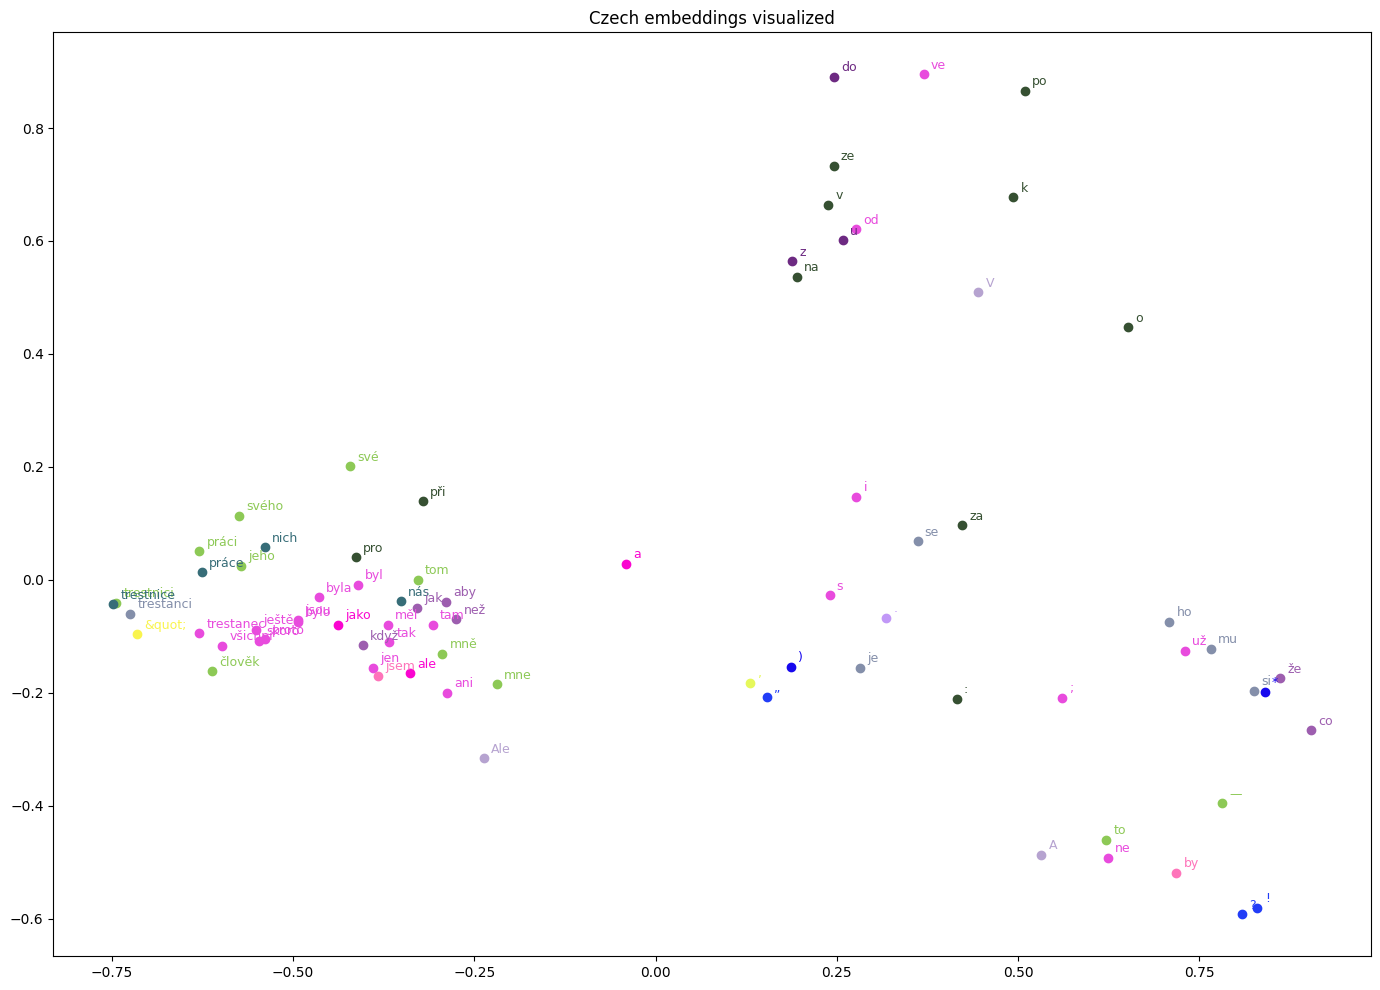

In [61]:
plot_embeddings(reduced_cs, starting_words["cs"], w2c["cs"], "Czech embeddings visualized")

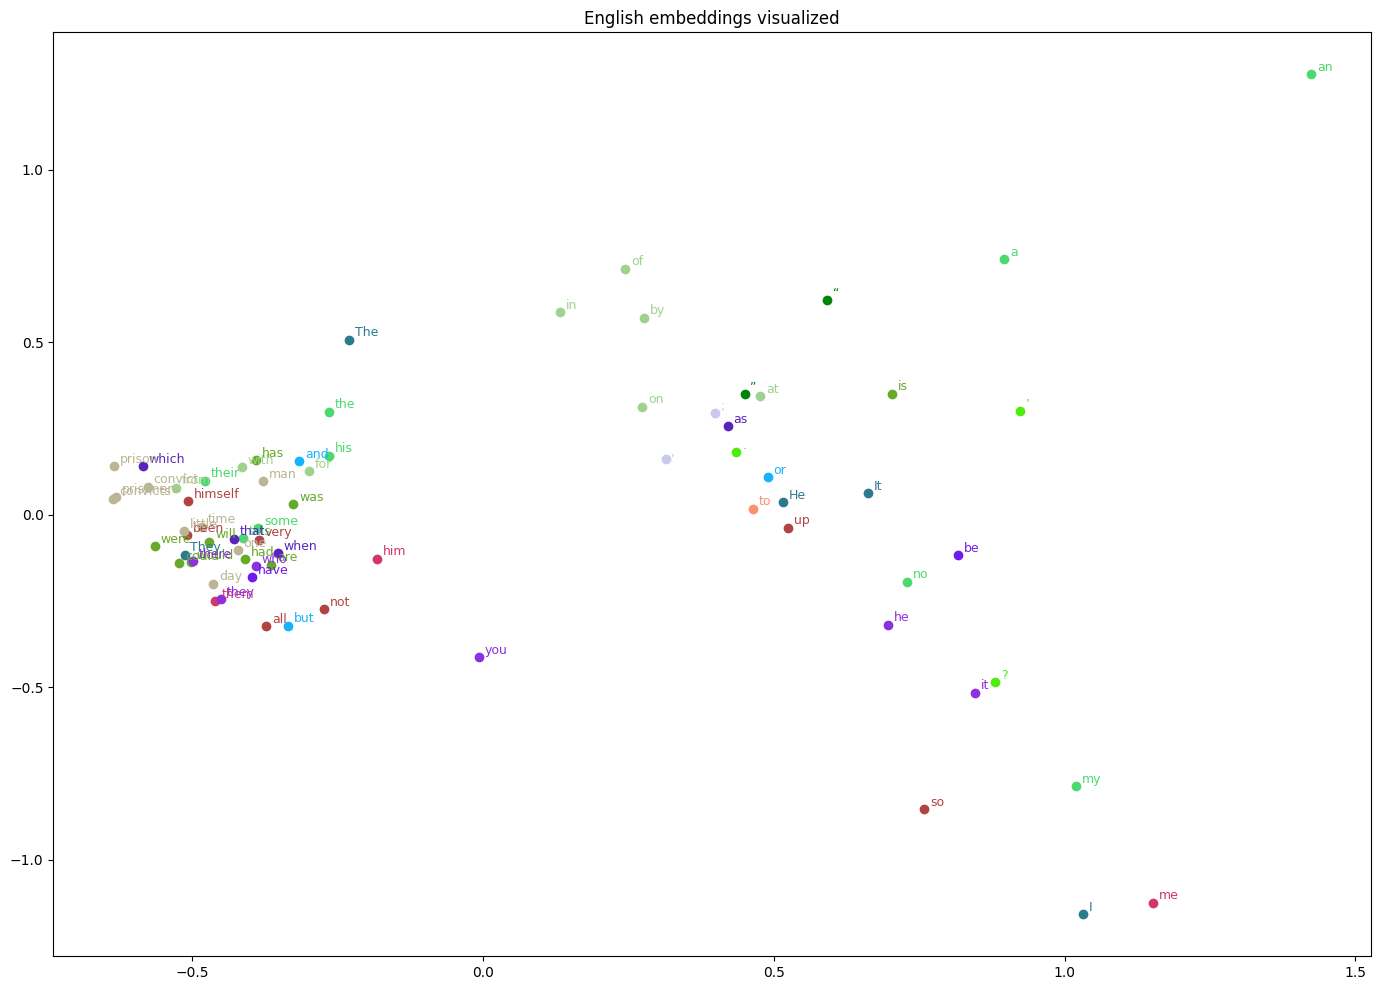

In [62]:
plot_embeddings(reduced_en, starting_words["en"], w2c["en"], "English embeddings visualized")

In [ ]:
from sklearn.cluster import KMeans
kmeans_cs = KMeans(n_clusters=15, random_state=0).fit(embeddings_cs)
kmeans_en = KMeans(n_clusters=15, random_state=0).fit(embeddings_en)

kmeans_classes_cs = {
    w:i for w,i in zip(starting_words["cs"], kmeans_cs.labels_)
}
kmeans_classes_en = {
    w:i for w,i in zip(starting_words["en"], kmeans_en.labels_)
}

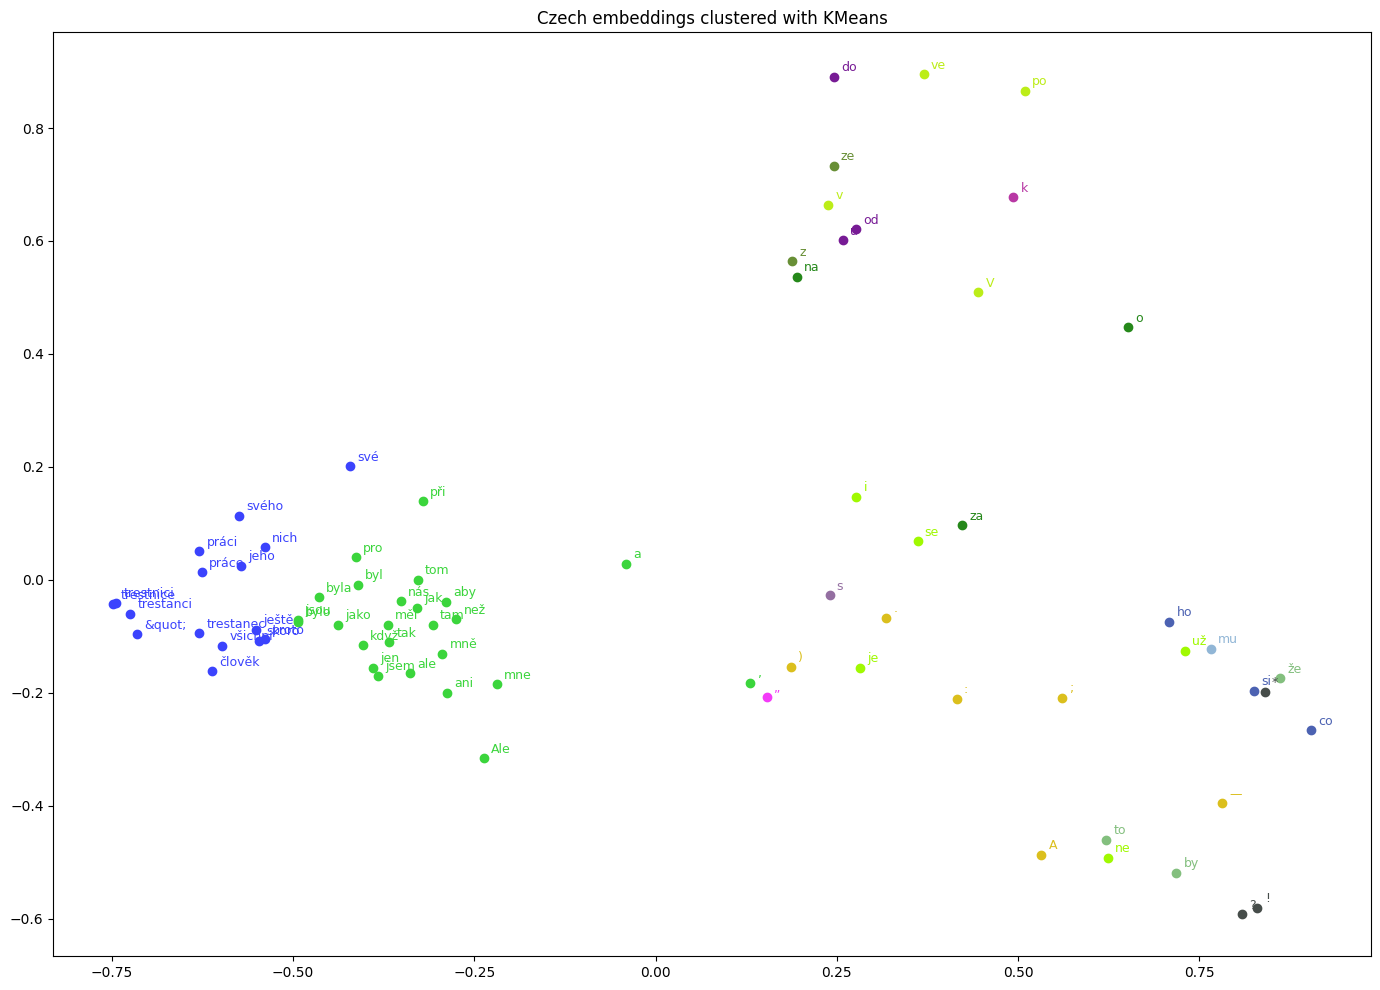

In [66]:
plot_embeddings(reduced_cs, starting_words["cs"], kmeans_classes_cs, "Czech embeddings clustered with KMeans")

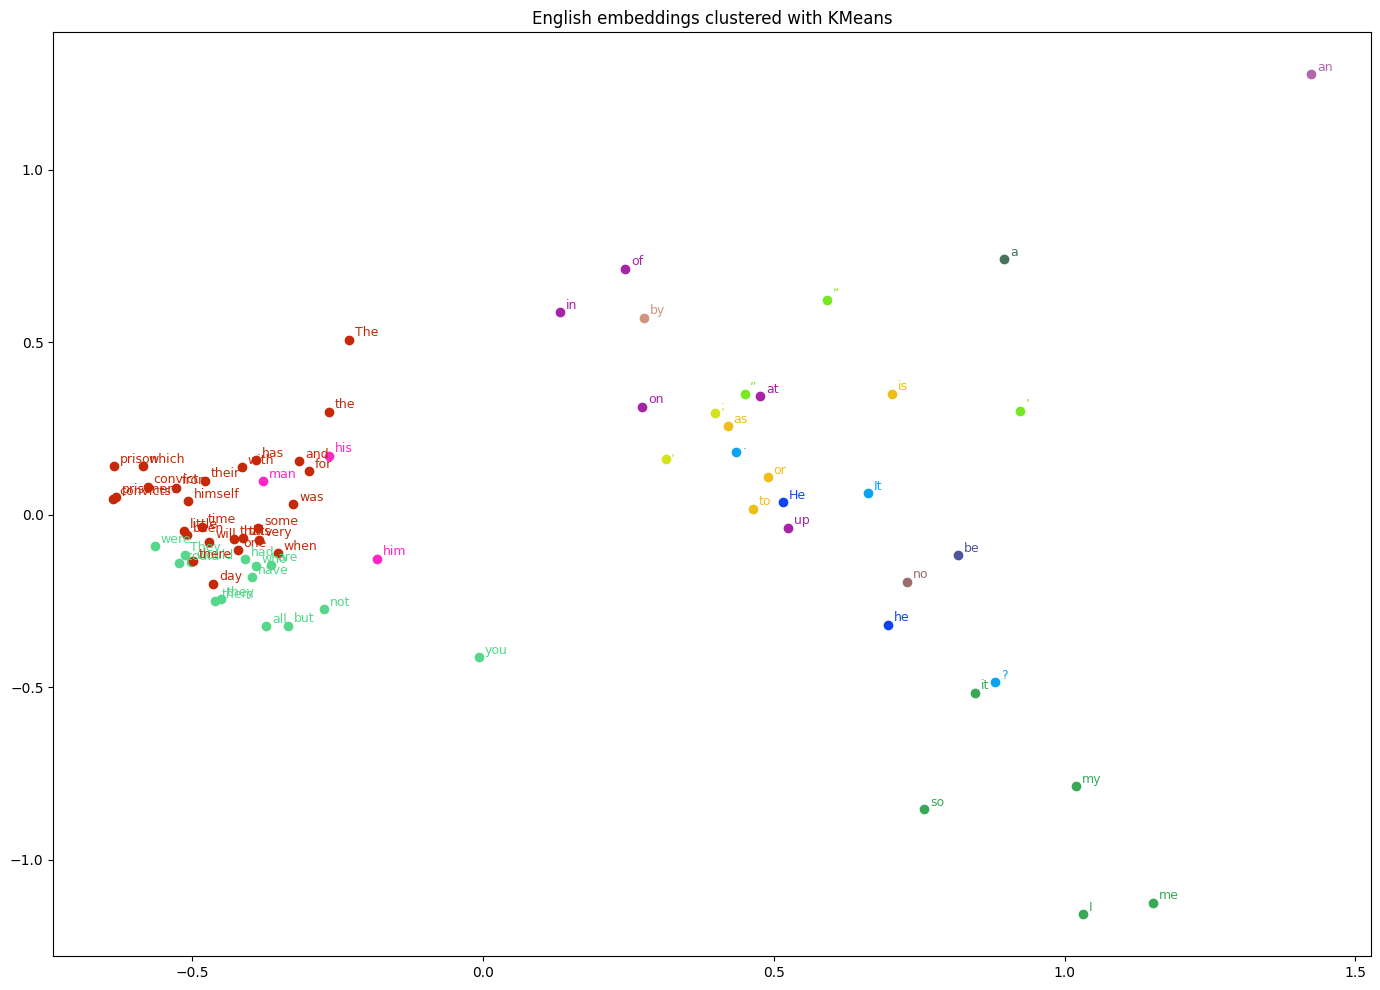

In [67]:
plot_embeddings(reduced_en, starting_words["en"], kmeans_classes_en, "English embeddings clustered with KMeans")